In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("input/data-salary.txt")
print(df.head(1))
print(df.shape)
X = df.X.values
y = df.Y.values
N = df.shape[0]

    X    Y
0  24  472
(20, 2)


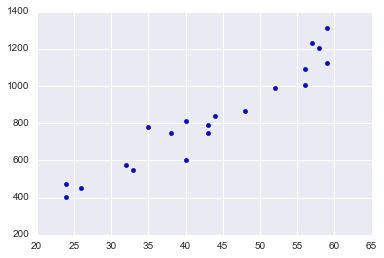

In [5]:
plt.scatter(X, y)

In [6]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
res_lm = smf.ols('Y ~ X', data=df).fit()
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     208.2
Date:                Fri, 11 Nov 2016   Prob (F-statistic):           2.47e-11
Time:                        00:17:13   Log-Likelihood:                -114.74
No. Observations:                  20   AIC:                             233.5
Df Residuals:                      18   BIC:                             235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -119.6971     68.148     -1.756      0.096      -262.871    23.477
X             21.9042      1.518     14.428      0.000        18.715    25.094
==============================================================================
Omnibus:                        0.099   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.216
Skew:                           0.140   Prob(JB):                        0.898
Kurtosis:                       2.575   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
from statsmodels.stats.outliers_influence import summary_table
st, data, _ = summary_table(res_lm, alpha=0.05)
st5, data5, _ = summary_table(res_lm, alpha=0.5)

In [8]:
st

Obs,Dep Var,Predicted,Std Error,Mean ci,Mean ci,Predict ci,Predict ci,Residual,Std Error,Student,Cook's
,Population,Value,Mean Predict,95% low,95% upp,95% low,95% upp,,Residual,Residual,D
1.0,472.0,406.003702271,34.2902643298,333.962530175,478.044874367,224.879500963,587.127903579,65.9962977289,71.2799011262,0.925875270394,0.0991933281345
2.0,403.0,406.003702271,34.2902643298,333.962530175,478.044874367,224.879500963,587.127903579,-3.00370227109,71.2799011262,-0.0421395403702,0.000205474097501
3.0,454.0,449.812105137,31.7276820162,383.154718703,516.469491571,270.761126395,628.863083879,4.18789486287,72.4568887425,0.0577984362225,0.000320272394109
4.0,575.0,581.237313735,24.6931088237,529.359017166,633.115610305,407.147097246,755.327530225,-6.23731373524,75.1458376026,-0.0830027841093,0.00037196065654
5.0,546.0,603.141515168,23.6587034885,553.436423566,652.846606771,429.686500961,776.596529375,-57.1415151683,75.4778926681,-0.75706293788,0.0281563481188
6.0,781.0,646.949918034,21.7608051505,601.23216288,692.667673188,474.595170613,819.304665456,134.050081966,76.0467875165,1.76273168589,0.127212738556
7.0,750.0,712.662522333,19.4628637173,671.772562983,753.552481683,541.525049529,883.799995138,37.3374776666,76.6670950819,0.487007856849,0.00764253447968
8.0,601.0,756.470925199,18.4037651513,717.80604937,795.135801029,585.851411528,927.09043887,-155.470925199,76.928200035,-2.02098742891,0.116879797885
9.0,814.0,756.470925199,18.4037651513,717.80604937,795.135801029,585.851411528,927.09043887,57.5290748006,76.928200035,0.747828166712,0.0160035328303


In [9]:
predicted_value = data[:,2].T
mean_ci_low, mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

#### confidence interval

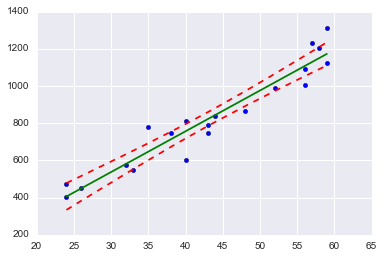

In [10]:
plt.scatter(X, y)
plt.plot(X, predicted_value, '-', color='g')
plt.plot(X, mean_ci_low, '--', color='r')
plt.plot(X, mean_ci_upp, '--', color='r')

#### prediction interval

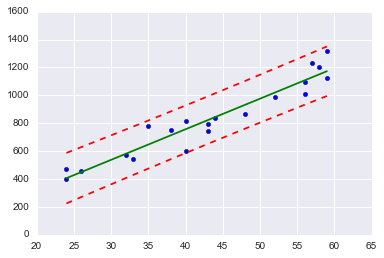

In [11]:
plt.scatter(X, y)
plt.plot(X, predicted_value, '-', color='g')
plt.plot(X, predict_ci_low, '--', color='r')
plt.plot(X, predict_ci_upp, '--', color='r')

### 4.4.5 stanで実装

In [12]:
import pystan
stan_data = {'N':N, 'X':X, 'Y': y}
fit = pystan.stan(file='input/model4-5.stan', data=stan_data, seed=1234)

In [13]:
fit

Inference for Stan model: anon_model_b434bb1e5d9d51500bfdc976c8c173bc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -123.4    3.24  73.86 -264.7 -172.1 -123.6 -76.07  25.18    520    1.0
b      21.98    0.07   1.64  18.73  20.94  21.99  23.07   25.1    517    1.0
sigma  84.96     0.6  15.58  61.47  73.85  82.75  93.29 121.64    677    1.0
lp__  -93.64    0.06   1.34 -97.23  -94.2 -93.29 -92.67 -92.14    539    1.0

Samples were drawn using NUTS(diag_e) at Fri Nov 11 00:17:55 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

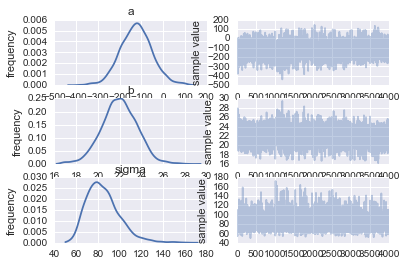

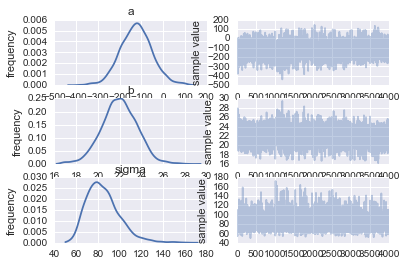

In [14]:
fit.plot()

#TODO chain毎にplotの色変える、グラフの重なりをなくす 

### 4.4.9 MCMCの設定変更

In [15]:
stanmodel = pystan.StanModel(file='input/model4-5.stan')

In [16]:
fit_modified = stanmodel.sampling(data=stan_data, pars=["b", "sigma"], 
                                   init=lambda: {"a":np.random.uniform(-10,10, 1)[0],"b":np.random.uniform(-10,10,1)[0], "sigma":10},seed=123, chains=3, iter=1000,warmup=200, thin=2)

In [17]:
fit_modified

Inference for Stan model: anon_model_b434bb1e5d9d51500bfdc976c8c173bc.
3 chains, each with iter=1000; warmup=200; thin=2; 
post-warmup draws per chain=400, total post-warmup draws=1200.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b      21.86     0.1   1.62  18.59  20.83  21.82  22.93  25.13    274    1.0
sigma  84.64    0.85  15.62  60.08  73.56  82.37  93.79 122.89    341    1.0
lp__  -93.65    0.07    1.3 -96.95 -94.22 -93.32 -92.72 -92.18    315    1.0

Samples were drawn using NUTS(diag_e) at Fri Nov 11 00:18:36 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

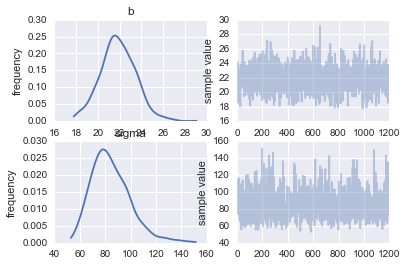

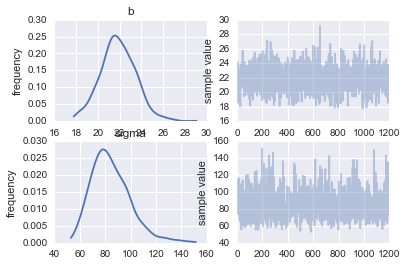

In [18]:
fit_modified.plot()

In [19]:
# コンパイルを省くためにモデル保存
import pickle
with open("tmp/4-4-9stanmodel.model", "wb") as f:
    pickle.dump(stanmodel, f)

#### 4.4.11 ベイズ信頼区間とベイズ予測区間の算出

In [20]:
ms = fit.extract()

In [21]:
ms["b"] # warmup期間はあらかじめ取り除き、MCMCサンプルを混ぜて並び替えたもの

array([ 19.5591921 ,  23.22101188,  23.17984651, ...,  19.5506656 ,
        21.54689547,  23.18543629])

In [22]:
np.percentile(ms["b"],[2.5,97.5])

array([ 18.72960419,  25.10164668])

In [23]:
d_mcmc = pd.DataFrame({"a":ms["a"], "b":ms["b"], "sigma":ms["sigma"]})

In [24]:
d_mcmc.head(2)

,a,b,sigma
0,-81.091257,19.559192,109.728884
1,-197.049822,23.221012,77.374026


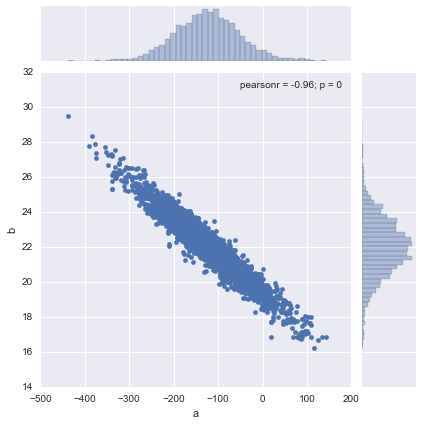

In [25]:
sns.jointplot(x="a", y="b",data=d_mcmc)

In [26]:
N_mcmc = len(ms["lp__"])
y50_base = ms["a"] + ms["b"] * 50

In [27]:
y50_base

array([ 896.86834801,  964.00077207,  987.34755959, ...,  955.4625731 ,
        969.36258588,  978.22038508])

In [28]:
y50 = np.random.normal(y50_base, ms["sigma"], size=N_mcmc)

In [29]:
d_mcmc = pd.DataFrame({"a":ms["a"], "b":ms["b"], "sigma":ms["sigma"], "y50_base":y50_base, "y50":y50})

In [30]:
d_mcmc.head(2)

,a,b,sigma,y50,y50_base
0,-81.091257,19.559192,109.728884,821.443104,896.868348
1,-197.049822,23.221012,77.374026,961.030309,964.000772


#### 信頼区間50, 95%算出

In [31]:
X_new = np.arange(23,60)
y_new = ms["a"] + ms["b"] * X_new[:, np.newaxis]
y_med = [np.median(_y) for _y in y_new]

conf_low_95 = []
conf_upp_95 = []
conf_low_50 = []
conf_upp_50 = []
for _x, _y in zip(X_new, y_new):
    pred_95 = np.percentile(_y,[2.5,97.5])
    pred_50 = np.percentile(_y,[25,75])
    conf_low_95.append(pred_95[0])
    conf_upp_95.append(pred_95[1])
    conf_low_50.append(pred_50[0])
    conf_upp_50.append(pred_50[1])
    

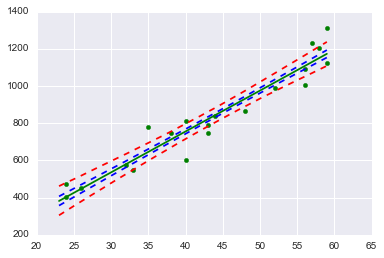

In [32]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, conf_low_95, '--', color='r')
plt.plot(X_new, conf_upp_95, '--', color='r')
plt.plot(X_new, conf_low_50, '--', color='b')
plt.plot(X_new, conf_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

#### 予測区間50, 95%算出

In [33]:
# mu=y_base, sigma=sigmaの正規分布よりサンプリング
pred_low_95 = []
pred_upp_95 = []
pred_low_50 = []
pred_upp_50 = []
for _y in y_new:
    y_sample = np.random.normal(_y, ms["sigma"], size=N_mcmc)
    pred_95 = np.percentile(y_sample,[2.5,97.5])
    pred_50 = np.percentile(y_sample,[25,75])
    pred_low_95.append(pred_95[0])
    pred_upp_95.append(pred_95[1])
    pred_low_50.append(pred_50[0])
    pred_upp_50.append(pred_50[1])

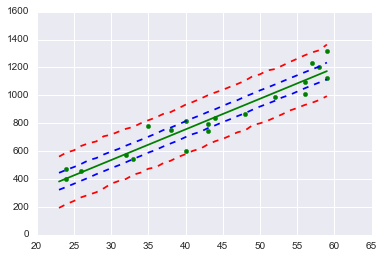

In [34]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, pred_low_95, '--', color='r')
plt.plot(X_new, pred_upp_95, '--', color='r')
plt.plot(X_new, pred_low_50, '--', color='b')
plt.plot(X_new, pred_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

#### 4.4.12 transformed parameters ブロックとgenerated quantitiesブロック

In [35]:
stan_data_new = {'N':N, 'X':X, 'Y': y, "N_new": len(X_new), "X_new":X_new}
fit_new = pystan.stan(file='input/model4-5-new.stan', data=stan_data_new, seed=1234)

In [36]:
ms_new = fit_new.extract()

In [37]:
ms_new["y_new"][:,:4]

array([[ 259.52682068,  116.47983111,  479.66986624,  133.38347767],
       [ 361.47990482,  367.79935664,  569.26136827,  455.14365966],
       [ 412.38092975,  517.57109176,  364.08076871,  609.67027982],
       ..., 
       [ 478.94176541,  358.73539349,  469.45797582,  421.3915409 ],
       [ 382.15017057,  423.87727412,  429.77479057,  484.09284028],
       [ 402.34453751,  478.26127332,  410.33428334,  542.4903747 ]])

In [38]:
y_base = ms_new["y_base"]
y_new = ms_new["y_new"]
y_base_new = ms_new["y_base_new"]

In [39]:
# 信用区間
conf_low_95 = []
conf_upp_95 = []
conf_low_50 = []
conf_upp_50 = []
for _x, _y in zip(X_new, y_base_new.T):
    pred_95 = np.percentile(_y,[2.5,97.5])
    pred_50 = np.percentile(_y,[25,75])
    conf_low_95.append(pred_95[0])
    conf_upp_95.append(pred_95[1])
    conf_low_50.append(pred_50[0])
    conf_upp_50.append(pred_50[1])

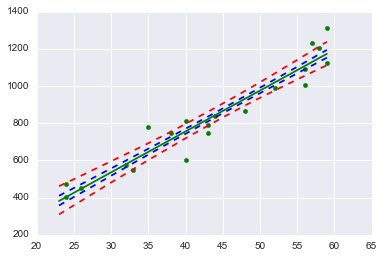

In [40]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, conf_low_95, '--', color='r')
plt.plot(X_new, conf_upp_95, '--', color='r')
plt.plot(X_new, conf_low_50, '--', color='b')
plt.plot(X_new, conf_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

In [41]:
#　予測区間
# mu=y_base, sigma=sigmaの正規分布よりサンプリング
pred_low_95 = []
pred_upp_95 = []
pred_low_50 = []
pred_upp_50 = []
for _y in y_new.T:
    y_sample = np.random.normal(_y, ms["sigma"], size=N_mcmc)
    pred_95 = np.percentile(y_sample,[2.5,97.5])
    pred_50 = np.percentile(y_sample,[25,75])
    pred_low_95.append(pred_95[0])
    pred_upp_95.append(pred_95[1])
    pred_low_50.append(pred_50[0])
    pred_upp_50.append(pred_50[1])

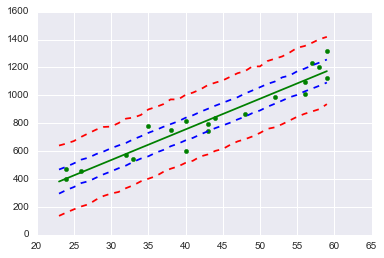

In [42]:
plt.plot(X_new, y_med, '-', color='g')
plt.plot(X_new, pred_low_95, '--', color='r')
plt.plot(X_new, pred_upp_95, '--', color='r')
plt.plot(X_new, pred_low_50, '--', color='b')
plt.plot(X_new, pred_upp_50, '--', color='b')
plt.scatter(X, y, color='g')

In [43]:
ms_new["y_new"][:,:4]

array([[ 259.52682068,  116.47983111,  479.66986624,  133.38347767],
       [ 361.47990482,  367.79935664,  569.26136827,  455.14365966],
       [ 412.38092975,  517.57109176,  364.08076871,  609.67027982],
       ..., 
       [ 478.94176541,  358.73539349,  469.45797582,  421.3915409 ],
       [ 382.15017057,  423.87727412,  429.77479057,  484.09284028],
       [ 402.34453751,  478.26127332,  410.33428334,  542.4903747 ]])

#### 練習問題

In [46]:
N1 = 30
N2 = 20
Y1 = np.random.normal(0,5,N1)
Y2 = np.random.normal(1,4,N2)
kind = ["Y1"] * N1 + ["Y2"] * N2
data = np.r_[Y1,Y2]
dataframe = pd.DataFrame({"kind":kind, "data":data})

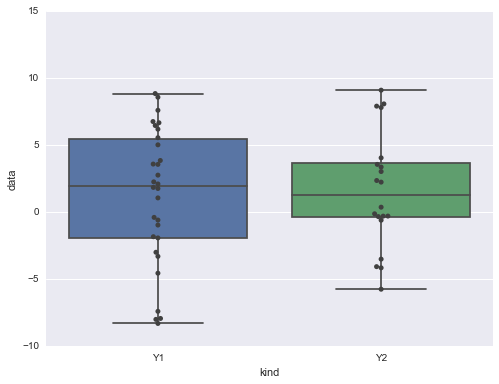

In [52]:
# (1) 各グループの値に差異が認められるか？
# →Y2の方が分散だけでなく、平均値もY1と比べて小さくみえる。
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="kind", y="data", data=dataframe)
ax = sns.swarmplot(x="kind", y="data", data=dataframe, color=".25")

(2)標準偏差が等しいとして、モデル式

Y1 ~ N(0, 5) n = 30

Y2 ~ N(1, 4) n = 20

In [87]:
# (3)
data = {"N1":N1, "N2":N2, "Y1":Y1, "Y2":Y2}
fit3 = pystan.stan(file="input/task3.stan",data=data)

In [88]:
fit3

Inference for Stan model: anon_model_23514f8f508e5e8643d911edc5e5033a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu1     1.21    0.03   0.93  -0.56   0.59    1.2   1.81   3.06   1058    1.0
mu2     1.63    0.03   1.12   -0.5   0.87   1.63   2.37   3.82   1118    1.0
sigma   4.97    0.02   0.53   4.07    4.6   4.92   5.29   6.13   1047    1.0
lp__  -102.6    0.05   1.28 -106.1 -103.2 -102.3 -101.7 -101.2    769    1.0

Samples were drawn using NUTS(diag_e) at Fri Nov 11 01:22:48 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

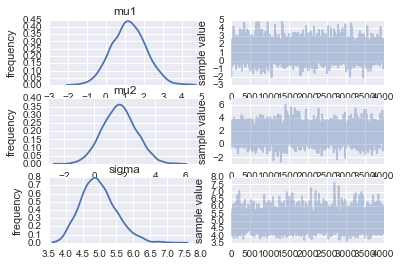

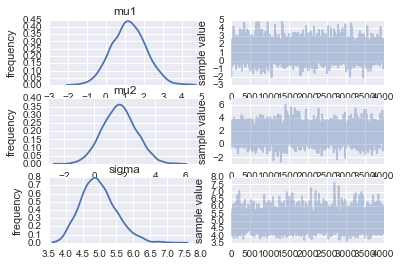

In [89]:
fit3.plot()

In [90]:
# (4)
ms3 = fit3.extract()

In [91]:
mu1_sample = ms3["mu1"]
mu2_sample = ms3["mu2"]

In [92]:
cnt = sum([1 for m1, m2 in zip(mu1_sample, mu2_sample) if m1 < m2])

In [93]:
print("Prob[mu1 < mu2]: %0.2f " % (cnt / len(mu1_sample) * 100))

Prob[mu1 < mu2]: 61.40 


In [95]:
# (5)
fit5 = pystan.stan(file="input/task5.stan",data=data)

In [96]:
fit5

Inference for Stan model: anon_model_4cbcc861908739618fcbf0bb4b6e612c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu1      1.21    0.03   0.99  -0.74   0.55   1.19   1.85   3.19   1110    1.0
mu2      1.64    0.04   1.09   -0.5   0.91   1.64   2.37   3.79    941    1.0
sigma1   5.32    0.02   0.74   4.11   4.79   5.23   5.76   6.97   1071    1.0
sigma2   4.66    0.03   0.83   3.38   4.09   4.56   5.11   6.61    924    1.0
lp__   -101.3    0.05   1.45 -104.9 -102.0 -101.0 -100.2 -99.51    865    1.0

Samples were drawn using NUTS(diag_e) at Fri Nov 11 01:24:59 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

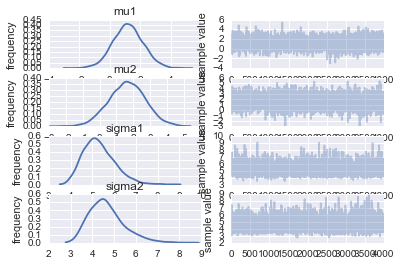

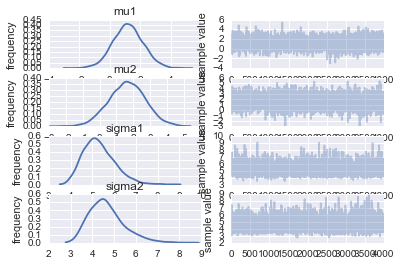

In [97]:
fit5.plot()

In [98]:
ms5 = fit5.extract()
mu1_sample_5 = ms5["mu1"]
mu2_sample_5 = ms5["mu2"]
cnt = sum([1 for m1, m2 in zip(mu1_sample_5, mu2_sample_5) if m1 < m2])
print("Prob[mu1 < mu2]: %0.2f " % (cnt / len(mu1_sample_5) * 100))

Prob[mu1 < mu2]: 61.42 


### 以下テスト

In [112]:
data = {"N1":N1, "N2":N2, "Y1":Y1, "Y2":Y2}
testfit = pystan.stan(file="input/test1.stan",data=data)

In [113]:
testfit

Inference for Stan model: anon_model_dfffbefd5defc78f4ec3f0deba27de53.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu1       1.18    0.03   0.98  -0.73   0.52   1.18   1.84   3.12   1044    1.0
mu2       1.56    0.03   1.07  -0.59   0.85   1.55   2.28   3.65   1100    1.0
sigma1    5.33    0.02   0.75   4.12   4.79   5.25   5.76   6.99   1114    1.0
sigma2    4.65    0.03   0.84   3.34   4.06   4.53   5.11   6.67   1043    1.0
mu_diff  -0.37    0.04   1.45   -3.2  -1.33  -0.36   0.58   2.53   1089    1.0
lp__    -101.3    0.05   1.46 -104.9 -102.0 -101.0 -100.2 -99.48    914    1.0

Samples were drawn using NUTS(diag_e) at Fri Nov 11 01:44:03 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

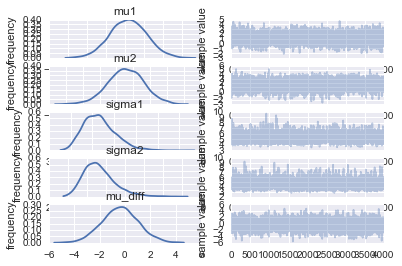

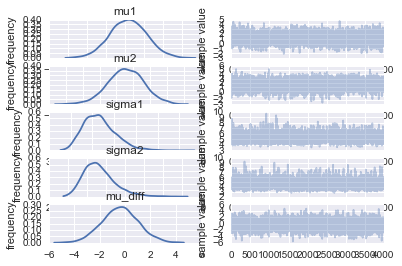

In [114]:
testfit.plot()

In [115]:
ms_test = testfit.extract()

In [116]:
ms_test

OrderedDict([('mu1',
              array([ 2.26185014, -0.14867196,  1.94102088, ...,  0.91288654,
                      1.1118667 , -0.21620372])),
             ('mu2',
              array([ 2.87355341, -1.5196057 ,  0.03646359, ...,  3.47264959,
                      1.82699573,  1.16772701])),
             ('sigma1',
              array([ 5.70126776,  6.10894962,  4.6245296 , ...,  4.7290146 ,
                      4.60420829,  5.81400087])),
             ('sigma2',
              array([ 4.54758287,  4.25968726,  5.84159228, ...,  5.5455157 ,
                      4.57820286,  4.22419947])),
             ('mu_diff',
              array([-0.61170327,  1.37093374,  1.90455728, ..., -2.55976305,
                     -0.71512903, -1.38393073])),
             ('lp__',
              array([-100.88204804, -106.21109573, -102.05602228, ..., -101.55746988,
                      -99.65196502, -100.68238568]))])

#### if else

In [117]:
test2fit = pystan.stan(file="input/test_if_else.stan",data=data,pars=["mu_diff"])

In [118]:
test2fit

Inference for Stan model: anon_model_75c5f44963de41fea3a81c6b834133da.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_diff   0.62    0.01   0.49    0.0    0.0    1.0    1.0    1.0   1186    1.0
lp__    -102.6    0.05   1.29 -105.9 -103.3 -102.3 -101.7 -101.2    752    1.0

Samples were drawn using NUTS(diag_e) at Fri Nov 11 01:44:46 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

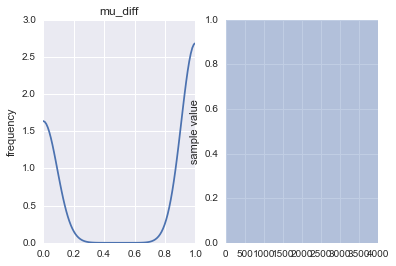

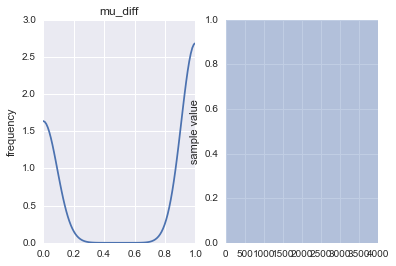

In [119]:
test2fit.plot()

In [120]:
ms_test2 = test2fit.extract()

In [121]:
tmp = ms_test2["mu_diff"]
tmp.sum() / len(tmp)

0.62124999999999997

In [122]:
len(tmp)

4000